# Loading
## Libraries
### Needed for the project


* This is a bullet List

1. This is a numerbed list
2. Numered list two

*These are italicized words, not a bullet list*
**These are bold words, not a bullet list**

***

Here is some important text!

***

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import dython as dy
import plotly.express as px
from pandas_profiling import ProfileReport
from catboost import CatBoostRegressor
from sklearn.preprocessing import MultiLabelBinarizer, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from hyperopt import space_eval
import pandas as pd
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold, train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import plotly.figure_factory as ff
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from hyperopt import Trials, STATUS_OK, tpe, hp, fmin
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('./data/dataset.csv')
# Setting id as index
df.set_index('id', inplace=True)

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df.values, df.fertilizer_usage.values):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

X_train = train_set.drop(columns='yield')
y_train = train_set['yield']
X_test = test_set.drop(columns='yield')
y_test = test_set['yield']

In [10]:
# Custom Transformer that extracts columns passed as argument to its constructor
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor
    def __init__( self, feature_names):
        self.feature_names = feature_names

    #Return self nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[self.feature_names]

# Will handle water, uv, area, pesticides- fill missing values and scale

class NumericalTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self):
        pass

    #Return self, nothing else to do here
    def fit( self, X, y = None ):
        return self

    #Custom transform method we wrote that creates aformentioned features and drops redundant ones
    def transform(self, X, y = None):

        for col in X.columns:
            # Adjusting outliers with their percentile values
            low = X[col].quantile(0.01)
            high = X[col].quantile(0.99)

            X[col] = np.where(X[col] < low, low,X[col])
            X[col] = np.where(X[col] > high, high,X[col])

            # # Filling the Missing Values
            # X[col] = X.groupby('region')[col].transform(lambda x: x.fillna(x.mean()))
        self.num_columns = X.columns
        #returns a numpy array
        return X.values


# Now categorical variables

class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self):
        pass

    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self

    #Transformer method we wrote for this transformer
    def transform(self, X , y = None ):
        #Depending on constructor argument break dates column into specified units
        #using the helper functions written above
        X = pd.get_dummies(X, columns=['region'], dtype=np.int64)

        # Splitting the entries so that it can be ingested to binarizer
        X['categories'] = X['categories'].transform(lambda x: x.split(','))

        mlb = MultiLabelBinarizer()
        cats = pd.DataFrame(mlb.fit_transform(X['categories']),columns=mlb.classes_, index=X.index)

        # Renaming the column value
        cats.columns = 'pesticide_' + cats.columns.values
        X = pd.concat([X.drop(columns='categories'), cats], axis=1)
        self.cat_columns = X.columns
        #returns numpy array
        return X.values


# Numerical features to pass down the numerical pipeline
numerical_features = ['water', 'uv', 'area', 'pesticides']

# Categorical features to pass donw the categorical pipeline
categorical_features = ['fertilizer_usage', 'region', 'categories']

#Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),

                                  ( 'num_transformer', NumericalTransformer() ),
                                    ('imputer', SimpleImputer(strategy = 'median') ),

                                  ( 'std_scaler', RobustScaler() ) ] )


#Defining the steps in the categorical pipeline
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),

                                  ( 'cat_transformer', CategoricalTransformer() )] )


#Combining numerical and categorical pipeline into one full big pipeline horizontally
#using FeatureUnion
processor_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ),

                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

Now, Hypereopt tuning

In [11]:
def objective_demo(args):
    pipe = Pipeline(steps=[
        ('preprocessor', processor_pipeline),
        ('model', args['model'])
    ])
    pipe.set_params(**args['params'])
    shuffle = KFold(n_splits=10, shuffle=True)
    try:
        score = cross_val_score(pipe, X_train, y_train, cv=shuffle, scoring='neg_mean_absolute_error', n_jobs=1)
        return -score.mean()
    except:
        pass
    return 0

100%|██████████| 100/100 [00:25<00:00,  3.87trial/s, best loss: 7.563143097848892]
Best Model: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.49, gamma=0.09, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.39, max_delta_step=0, max_depth=15,
             min_child_weight=4.0, missing=nan, monotone_constraints='()',
             n_estimators=105, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0.43167217629129184, reg_lambda=0.3880524020617887,
             scale_pos_weight=1, subsample=0.74, tree_method='exact',
             validate_parameters=1, verbosity=None) 
 

Mean Absolute Error by the Model:  9.380229884338378


<AxesSubplot:title={'center':'Feature Importance'}>

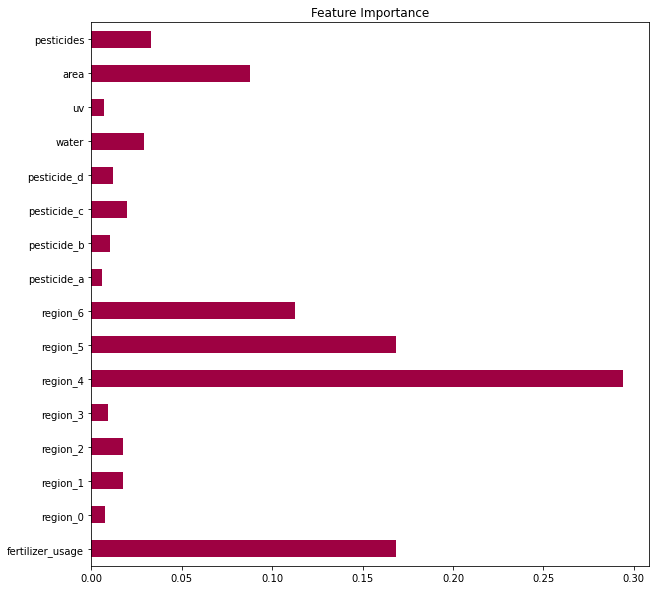

In [12]:
space_demo = hp.choice('regressors', [{
    'model': DummyRegressor(),
    'params':{}
    },
    {
    'model':SVR(),
    'params':{
        'model__C': hp.choice('C', np.arange(0.005,1.0,0.01)),
        'model__kernel': hp.choice('kernel',['linear', 'rbf']),
        'model__degree':hp.choice('degree',[2,3,4]),
        'model__gamma': hp.uniform('gamma',0.001,10000)
    }
    },
    {
    'model': XGBRegressor(),
    'params': {
        'model__max_depth' : hp.choice('xgb.max_depth', range(5, 30, 1)),
        'model__learning_rate' : hp.quniform('xgb.learning_rate', 0.01, 0.5, 0.01),
        'model__n_estimators' : hp.choice('xgb.n_estimators', range(20, 205, 5)),
        'model__gamma' : hp.quniform('xgb.gamma', 0, 0.50, 0.01),
        'model__min_child_weight' : hp.quniform('xgb.min_child_weight', 1, 10, 1),
        'model__subsample' : hp.quniform('xgb.subsample', 0.1, 1, 0.01),
        'model__colsample_bytree' : hp.quniform('xgb.colsample_bytree', 0.1, 1.0, 0.01),
        'model__reg_lambda' : hp.uniform ('xgb.reg_lambda', 0,1),
        'model__reg_alpha' : hp.uniform ('xgb.reg_alpha', 0,1)
    },
    },
    {
    'model': LGBMRegressor(),
    'params': {
        'model__class_weight': hp.choice('lgbm.class_weight', [None, 'balanced']),
        'model__boosting_type': hp.choice('lgbm.boosting_type',
                                        [{'boosting_type': 'gbdt',
                                         },
                                        {'boosting_type': 'dart',
                                         },
                                        {'boosting_type': 'goss'}]),
        'model__num_leaves': hp.quniform('lgbm.num_leaves', 30, 150, 1),
        'model__learning_rate': hp.loguniform('lgbm.learning_rate', np.log(0.01), np.log(0.2)),
        'model__subsample_for_bin': hp.quniform('lgbm.subsample_for_bin', 20000, 300000, 20000),
        'model__feature_fraction': hp.uniform('lgbm.feature_fraction', 0.5, 1),
        'model__bagging_fraction': hp.uniform('lgbm.bagging_fraction', 0.5, 1), #alias "subsample"
        'model__min_data_in_leaf': hp.qloguniform('lgbm.min_data_in_leaf', 0, 6, 1),
        'model__lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'model__lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'model__verbose': -1,
        'model__subsample': None, #overridden by bagging_fraction
        'model__reg_alpha': None, #overridden by lambda_l1
        'model__reg_lambda': None, #overridden by lambda_l2
        'model__min_sum_hessian_in_leaf': None, #overrides min_child_weight
        'model__min_child_samples': None, #overridden by min_data_in_leaf
        'model__colsample_bytree': None, #overridden by feature_fraction
        'model__min_child_weight': hp.loguniform('lgbm.min_child_weight', -16, 5), #also aliases to min_sum_hessian
    }
    },
    {
    'model': CatBoostRegressor(task_type='GPU'),
    'params': {
        'model__max_depth' : hp.choice('cat.max_depth', range(5, 30, 1)),
        'model__learning_rate' : hp.quniform('cat.learning_rate', 0.01, 0.5, 0.01),
        'model__n_estimators' : hp.choice('cat.n_estimators', range(20, 205, 5)),
        'model__subsample' : hp.quniform('cat.subsample', 0.1, 1, 0.01),
        'model__reg_lambda' : hp.uniform ('cat.reg_lambda', 0,1),
        'model__num_leaves': hp.quniform('cat.num_leaves', 31, 60, 1)
    }
    }
])

best_regressor = fmin(objective_demo,space_demo,
                        algo=tpe.suggest,max_evals=100)

best_params = space_eval(space_demo, best_regressor)

final_pipe = Pipeline(steps=[
    ('processor', processor_pipeline),
    ('model', best_params['model'])
])
final_pipe.fit(X_train, y_train)
y_pred=final_pipe.predict(X_test)
print(f'Best Model: {best_params["model"]} \n \n')
print('Mean Absolute Error by the Model: ', mean_absolute_error(y_test, y_pred))


columns_processed= list(final_pipe.named_steps['processor'].transformer_list[0][1][1].cat_columns) + \
list(final_pipe.named_steps['processor'].transformer_list[1][1][1].num_columns)

dt = pd.DataFrame(final_pipe.named_steps['model'].feature_importances_).transpose()
dt.columns = columns_processed
dt.transpose().plot(kind='barh', figsize=(10,10), title='Feature Importance', legend=False, colormap='Spectral')